In [1]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete
from ray.rllib.utils.spaces.repeated import Repeated
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy

In [2]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        randomized = list(self.devices.keys())
        random.shuffle(randomized)
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: randomized[:bound],
            1: randomized[bound:bound*2],
            2: randomized[bound*2:bound*3],
            3: randomized[bound*3:]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def rl_update(self, new_allocation):
        self.data_allocation = new_allocation
        self.construct_dictionaries()
        return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation - 10],1)
            self.action_device.append(device[0])
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(52 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()


In [27]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]
architecture = Architecture()

for j in executions:
    architecture.heart_beat()
    for h in j:
        architecture.generate(h)
    print(len(architecture.greedy_algorithm()))

52
52
52
52
52
52
52
52
52


In [3]:
class AcesArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.weigths = self.architecture.weights
        self.allocation = self.architecture.data_allocation
        self.data_types = self.architecture.data_types
        self.free_space = list(self.architecture.free_space().values())
        self.last_calls_type = self.architecture.action_type
        self.last_calls_device = self.architecture.action_device

        self.observation_space = Dict({
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "allocation": Box(low=-1, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32),
            "data_type": Box(low=-1, high=3, shape=(maximum_data,), dtype=np.int32),
            "free_space": Box(low=-10, high=1, shape=(self.num_devices,), dtype=np.float32),
            "last_calls_type": Box(low=-1, high=13, shape=(10,), dtype=np.int32),
            "last_calls_device": Box(low=-1, high=self.num_devices-1, shape=(10,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.allocation_length = len(self.allocation)

        self.reward = 0

    def get_obs(self):

        return {
            "weights": np.array(self.weigths),
            "allocation": np.array(self.allocation),
            "data_type": np.array(self.data_types),
            "free_space": np.array(self.free_space),
            "last_calls_type": np.array(self.last_calls_type),
            "last_calls_device": np.array(self.last_calls_device)
        }

    def step(self,action):
        self.architecture.data_allocation = list(action[:self.allocation_length])
        self.allocation[:self.allocation_length] = list(action[:self.allocation_length])
        self.architecture.construct_dictionaries()
        normalized_latency = self.architecture.compute_normalized_latency()
        # normalized_latency = 0
        self.free_space = list(self.architecture.free_space().values())

        # flag = False
        # for i in self.free_space:
        #     if i <= self.architecture.min_free_space:
        #         flag = True
        #         break
        #
        # if flag:
        #     self.reward = -3
        # else:
        #     w1 = 2
        #     w2 = 1
        #     std = np.std(self.free_space)
        #     self.reward = w1*(1 - normalized_latency) + w2*(1-std)
        self.reward = (1 - normalized_latency) - 0.5

        done = True
        info = {}

        return self.get_obs(), self.reward, done, info

    def reset(self):
        if self.reward < -10:
            return self.get_obs()
        else:
            self.architecture.heart_beat()
            for execution in self.executions[self.execution_index]:
                self.architecture.generate(execution)
            self.allocation = self.architecture.data_allocation.copy()
            self.data_types = self.architecture.data_types.copy()
            self.allocation_length = len(self.allocation)
            for minus_one in range(self.maximum_data - len(self.allocation)):
                self.allocation.append(-1)
                self.data_types.append(-1)
            self.free_space = list(self.architecture.free_space().values())
            self.last_calls_type = self.architecture.action_type.copy()
            self.last_calls_device = self.architecture.action_device.copy()
            for minus_one in range(10 - len(self.last_calls_type)):
                self.last_calls_type.append(-1)
                self.last_calls_device.append(-1)

            self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
            return self.get_obs()

    def close(self):
        print('CLOSED')

In [4]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import TimeLimit
from gymnasium.wrappers import EnvCompatibility

check_env(TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10))

2023-06-07 12:44:23,008	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-07 12:44:23,008	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [38]:
# __sphinx_doc_begin__
import gymnasium as gym
import numpy as np
import os

import ray._private.utils

from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.evaluation.sample_batch_builder import SampleBatchBuilder
from ray.rllib.offline.json_writer import JsonWriter

if __name__ == "__main__":
    batch_builder = SampleBatchBuilder()  # or MultiAgentSampleBatchBuilder
    writer = JsonWriter(
        # "TFM/datasets/offline/100000"
        os.path.join(ray._private.utils.get_user_temp_dir(), "100000")
    )

    # You normally wouldn't want to manually create sample batches if a
    # simulator is available, but let's do it anyways for example purposes:
    env = AcesArchitectureEnv(52)

    # RLlib uses preprocessors to implement transforms such as one-hot encoding
    # and flattening of tuple and dict observations. For CartPole a no-op
    # preprocessor is used, but this may be relevant for more complex envs.
    prep = get_preprocessor(env.observation_space)(env.observation_space)
    print("The preprocessor is", prep)

    for eps_id in tqdm(range(100000)):
        obs, info = env.reset(), {}
        prev_action = np.zeros_like(env.action_space.sample())
        prev_reward = 0
        terminated = truncated = False
        t = 0
        while not terminated and not truncated:
            # action = env.action_space.sample()
            action = env.architecture.greedy_algorithm()
            new_obs, rew, terminated, info = env.step(action)
            batch_builder.add_values(
                t=t,
                eps_id=eps_id,
                agent_index=0,
                obs=prep.transform(obs),
                actions=action,
                action_prob=0.1,  # put the true action probability here
                action_logp=np.log(0.1),
                rewards=rew,
                prev_actions=prev_action,
                prev_rewards=prev_reward,
                terminateds=terminated,
                truncateds=truncated,
                infos=info,
                new_obs=prep.transform(new_obs)
            )
            obs = new_obs
            prev_action = action
            prev_reward = rew
            t += 1
        # writer.write(batch_builder.build_and_reset())
# __sphinx_doc_end__

The preprocessor is <ray.rllib.models.preprocessors.DictFlatteningPreprocessor object at 0x7ff16d7a24a0>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:49<00:00, 2024.81it/s]


In [10]:
from ray.rllib.algorithms.bc import BCConfig
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from gymnasium.wrappers import TimeLimit
from ray.rllib.utils.test_utils import check_train_results

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)
path = "TFM/datasets/online-offline/100"

config_bc = (
    BCConfig()
    .environment(env="AcesArchitectureEnv",disable_env_checking=True)
    .offline_data(input_=path)
    .training(
        train_batch_size=2,
        # twin_q=False,
    )
    .evaluation(
        evaluation_interval=5,
        evaluation_num_workers=1,
        evaluation_duration=5,
        evaluation_parallel_to_training=True,
        evaluation_config=BCConfig.overrides(input_="sampler"),
    )
    .rollouts(num_rollout_workers=1)
)
config_bc['model']['vf_share_layers'] = False
config_bc["model"]["fcnet_hiddens"] = [256,256,256,256]

algorithm_bc = config_bc.build()
for i in tqdm(range(10000)):
    result = algorithm_bc.train()
    check_train_results(result)
    # print(result)
    eval_results = result.get("evaluation")

2023-06-07 13:33:44,078	WARNING deprecation.py:50 -- DeprecationWarning: `MARWIL used to have off_policy_estimation_methods is and wis by default. This haschanged to off_policy_estimation_methods: \{\}.If you want to use an off-policy estimator, specify it in.evaluation(off_policy_estimation_methods=...)` has been deprecated. This will raise an error in the future!
2023-06-07 13:33:46,653	INFO worker.py:1553 -- Started a local Ray instance.
Exception in thread Thread-318:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/executio

In [11]:
# checkpoint_path = algorithm_bc.save("./TFM/algorithms/offline/100000")

In [42]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=30,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[256,256,256,256]

# algorithm = config.build()
# algorithm.set_weights(algorithm_bc.get_weights())
# checkpoint_path = algorithm.save()
# print(checkpoint_path)
algorithm = config.build()
algorithm.restore("./TFM/algorithms/online_offline_1400/checkpoint_001477")

result_04 =[]

for j in tqdm(range(100)):
    result_train = algorithm.train()["episode_reward_mean"]
    result_04.append(result_train)
    if j % 20 == 0:
        print(result_train)
print(result_04)

2023-06-08 10:26:33,485	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-08 10:26:53,845	INFO trainable.py:172 -- Trainable.setup took 23.451 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-08 10:26:53,847	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-06-08 10:26:54,434	INFO trainable.py:791 -- Restored on 138.4.11.227 from checkpoint: TFM/algorithms/online_offline_1400/checkpoint_001477
2023-06-08 10:26:54,435	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 1477, '_timesteps_total': None, '_time_total': 20635.002279996872, '_episodes_total': 145761750}
  1%|█▏                                                                                                               | 1/100 [00:15<25:16, 15.32s/it]

-0.005828607920920033


  7%|███████▉                                                                                                         | 7/100 [01:45<23:31, 15.18s/it]Exception in thread Thread-16124:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 21%|███████████████████████▌                                                                       

-0.003943391766440725


 41%|█████████████████████████████████████████████▉                                                                  | 41/100 [10:19<14:47, 15.04s/it]

-0.004091251063868093


 61%|████████████████████████████████████████████████████████████████████▎                                           | 61/100 [15:22<09:48, 15.09s/it]

-0.0038225167606167477


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 81/100 [20:18<04:37, 14.59s/it]

-0.0028782878417128494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:59<00:00, 14.99s/it]

[-0.005828607920920033, -0.003968483164830302, -0.004144502870857281, -0.003683086930229785, -0.004534947831289944, -0.0042823122807423225, -0.0036503812690607583, -0.004303086786989002, -0.004840002445118094, -0.003611034904977376, -0.004681274489801026, -0.0045351966394449085, -0.003961938102238265, -0.004170860701605721, -0.0040026906221646156, -0.004343432535999303, -0.0045504772969006835, -0.0039668349442077986, -0.004436916671219602, -0.003997056600652988, -0.003943391766440725, -0.003503864108414445, -0.004789822192465174, -0.0039487771618370885, -0.00473162543346991, -0.004068958253744941, -0.004216550369834224, -0.004544287866904092, -0.004383798647198817, -0.004837569269812976, -0.003951416340317532, -0.0038368462272757842, -0.0040658729142222325, -0.004512156798663383, -0.0040173035229199225, -0.004460617706709391, -0.004529552270813012, -0.004252306277435749, -0.00423982831829347, -0.0038073825293714935, -0.004091251063868093, -0.003363618893127003, -0.0030893443830173504, 

In [ ]:
for j in tqdm(range(200)):
    result_train = algorithm.train()["episode_reward_mean"]
    result_04.append(result_train)
    if j % 40 == 0:
        print(result_train)
# print(result_02)
# checkpoint_path = algorithm.save("./TFM/algorithms/online_offline_1400")

  0%|▌                                                                                                                | 1/200 [00:15<52:07, 15.72s/it]

-0.0036212911471021287


 20%|██████████████████████▉                                                                                         | 41/200 [10:09<39:13, 14.80s/it]

-0.004172130373989803


 40%|█████████████████████████████████████████████▎                                                                  | 81/200 [19:46<28:57, 14.60s/it]

-0.003446328910856955


 41%|█████████████████████████████████████████████▉                                                                  | 82/200 [19:59<28:04, 14.27s/it]

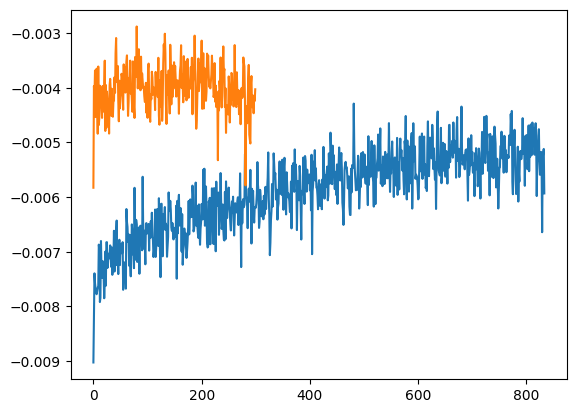

In [48]:
# plt.plot(result)
# plt.plot(result_02)
plt.plot(result_03)
plt.plot(result_04)

In [7]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
    .offline_data(output="TFM/datasets/online-offline/100")
)
# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[256,256,256,256]

algorithm_online = config.build()

result_online =[]
for i in tqdm(range(100)):
    training_result = algorithm_online.train()["episode_reward_mean"]
    # training_result = algorithm_online.train()
    result_online.append(training_result)
    # print(training_result)
print(result_online)

2023-06-07 13:02:48,648	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-07 13:03:10,978	INFO trainable.py:172 -- Trainable.setup took 24.742 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-07 13:03:10,982	WARNING util.py:67 -- Install gputil for GPU system monitoring.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:42<00:00, 15.43s/it]


NameError: name 'result' is not defined

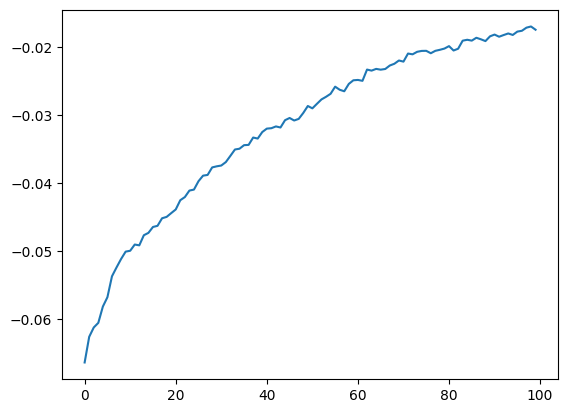

In [14]:
plt.plot(result_online)

In [ ]:
!ls /tmp/probability
# !cat /tmp/probability/output-2023-06-07_12-00-58_worker-1_2.json